In [31]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [32]:
ibov_close = pd.read_csv('./data/ativos_ibov/ivob_close.csv')

threshold = len(ibov_close)
ibov_close.dropna(thresh=threshold, axis=1, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])

ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2010-01-01':'2019-12-31']
returns = ibov_close.pct_change().dropna()

In [33]:
# Portfolio simples com rp
port = rp.Portfolio(returns=returns)

method_mu='hist'    # Method to estimate expected returns based on historical data.
method_cov='hist'   # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'           # Risk measure used, this time will be variance
obj = 'MinRisk'     # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True         # Use historical scenarios for risk measures that depend on scenarios
rf = 0              # Risk free rate
l = 0               # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
weights,3.673246e-09,1.327060e-08,1.909319e-08,0.100554,0.038285,4.355884e-09,0.18039,6.088590e-09,2.280721e-09,6.407689e-08,...,4.543655e-09,1.361299e-08,2.910673e-09,3.834077e-09,0.001925,0.198061,4.363208e-09,0.010311,0.176858,0.176522


In [34]:
brazil_holidays = holidays.Brazil()

# Filter the data for the first 10 years
first_year_data = ibov_close.loc['2010-01-01':'2019-12-31']

weights_df = pd.DataFrame()

# Loop through each month and calculate the weights
for month in pd.date_range(start='2010-01-01', end='2019-12-31', freq='ME'):
    # Adjust the date to the next business day if it falls on a weekend or holiday
    while month.weekday() >= 5 or month in brazil_holidays or month.is_year_end:  # 5 = Saturday, 6 = Sunday
        month += pd.offsets.BDay(1)
    
    # Get the data for the current month
    monthly_data = first_year_data.loc[:month.strftime('%Y-%m-%d')]
    
    # Calculate returns for the current month
    monthly_returns = monthly_data.pct_change().dropna()
    
    # Drop rows with NaNs or infinite values
    monthly_returns = monthly_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # Build the portfolio object
    port = rp.Portfolio(returns=monthly_returns)
    
    # Calculate optimal portfolio
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Store the weights in the dataframe
    w = w.T
    w['Date'] = month
    w.set_index('Date', inplace=True)
    weights_df = pd.concat([weights_df, w])

# Reindex the weights dataframe to match the index of the returns dataframe and fill missing values with the previous ones
weights_df = weights_df.reindex(returns.index, method='ffill')
weights_df = weights_df.dropna()

# Display the reindexed weights dataframe
weights_df

You must convert self.cov to a positive definite matrix


,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,1.056121e-09,3.971361e-08,9.556493e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145579e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430612e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-02,1.056121e-09,3.971361e-08,9.556493e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145579e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430612e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-03,1.056121e-09,3.971361e-08,9.556493e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145579e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430612e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-04,1.056121e-09,3.971361e-08,9.556493e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145579e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430612e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-05,1.056121e-09,3.971361e-08,9.556493e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145579e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430612e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,3.504961e-09,1.259007e-08,1.799684e-08,0.099994,0.038634,4.125696e-09,0.180467,5.705478e-09,2.177532e-09,7.119612e-08,...,4.333652e-09,1.264948e-08,2.760178e-09,3.639910e-09,2.031178e-03,0.197591,4.143296e-09,1.001956e-02,0.177046,0.177633
2019-12-23,3.504961e-09,1.259007e-08,1.799684e-08,0.099994,0.038634,4.125696e-09,0.180467,5.705478e-09,2.177532e-09,7.119612e-08,...,4.333652e-09,1.264948e-08,2.760178e-09,3.639910e-09,2.031178e-03,0.197591,4.143296e-09,1.001956e-02,0.177046,0.177633
2019-12-26,3.504961e-09,1.259007e-08,1.799684e-08,0.099994,0.038634,4.125696e-09,0.180467,5.705478e-09,2.177532e-09,7.119612e-08,...,4.333652e-09,1.264948e-08,2.760178e-09,3.639910e-09,2.031178e-03,0.197591,4.143296e-09,1.001956e-02,0.177046,0.177633


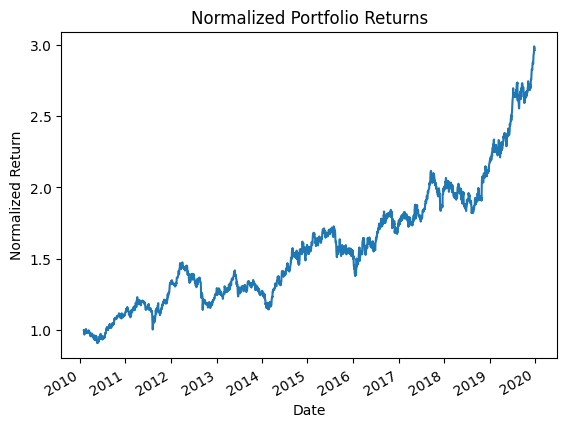

In [35]:
# Filter returns to have the same dates as weights_df
filtered_returns = returns.loc[weights_df.index]

# Calculate the portfolio returns - nx1 vector
portfolio_returns = (filtered_returns * weights_df).sum(axis=1)

# Normalize the portfolio returns to start at 1
normalized_portfolio_returns = (1 + portfolio_returns).cumprod()
normalized_portfolio_returns

# Plot the normalized portfolio returns
normalized_portfolio_returns.plot(title='Normalized Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [38]:
# Generate a binary array with 150 ones placed randomly
binary_array = np.zeros(len(returns.index))
binary_array[:150] = 1
np.random.shuffle(binary_array)

# Create a DataFrame to store the weights
weights_df_random = pd.DataFrame(index=returns.index, columns=returns.columns)

# Loop through each date and calculate the weights if the binary array value is 1
for date in returns.index[binary_array == 1]:
    # Get the data up to the current date
    data_up_to_date = returns.loc[:date]
    
    # Calculate returns up to the current date
    returns_up_to_date = data_up_to_date.pct_change().dropna()
    
    # Drop rows with NaNs or infinite values
    returns_up_to_date = returns_up_to_date.replace([np.inf, -np.inf], np.nan).dropna()

    # Build the portfolio object
    port = rp.Portfolio(returns=returns_up_to_date)
    
    # Calculate optimal portfolio
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)
    weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Store the weights in the dataframe
    weights_df_random.loc[date] = weights.T.values[0]

# Forward fill the weights to match the index of the returns dataframe and fill missing values with the previous ones
weights_df_random = weights_df_random.ffill().dropna()

# Filter returns to have the same dates as weights_df_random
filtered_returns_random = returns.loc[weights_df_random.index]

# Calculate the portfolio returns - nx1 vector
portfolio_returns_random = (filtered_returns_random * weights_df_random).sum(axis=1)

# Normalize the portfolio returns to start at 1
normalized_portfolio_returns_random = (1 + portfolio_returns_random).cumprod()

C:\Users\loren\AppData\Local\Temp\ipykernel_20288\1611461165.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights_df_random = weights_df_random.ffill().dropna()


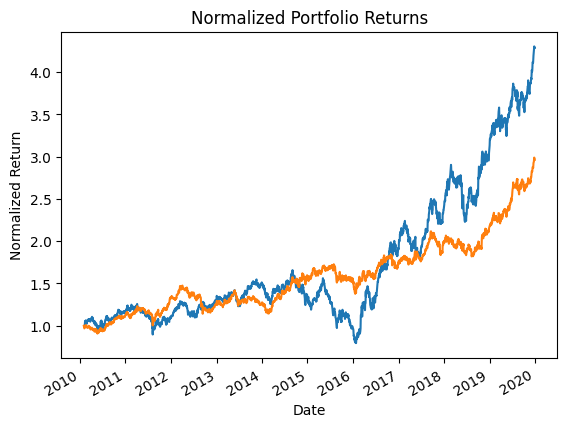

In [39]:
# Plot the normalized portfolio returns
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
normalized_portfolio_returns.plot(title='Normalized Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()